# PuppyFinder: A Dog Image Classification Project

*Tyler Tan & Chase Reynders*

## Introduction

We are using the [Stanford Dogs Dataset](https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset?resource=download), downloaded from Kaggle.

NOTE: we should cite the things it says we should on kaggle...





In [13]:
!pip3 install -r requirements.txt

ERROR: Could not find a version that satisfies the requirement ipython==8.23.0 (from -r requirements.txt (line 13)) (from versions: 0.10, 0.10.1, 0.10.2, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.13.2, 1.0.0, 1.1.0, 1.2.0, 1.2.1, 2.0.0, 2.1.0, 2.2.0, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 3.0.0, 3.1.0, 3.2.0, 3.2.1, 3.2.2, 3.2.3, 4.0.0b1, 4.0.0, 4.0.1, 4.0.2, 4.0.3, 4.1.0rc1, 4.1.0rc2, 4.1.0, 4.1.1, 4.1.2, 4.2.0, 4.2.1, 5.0.0b1, 5.0.0b2, 5.0.0b3, 5.0.0b4, 5.0.0rc1, 5.0.0, 5.1.0, 5.2.0, 5.2.1, 5.2.2, 5.3.0, 5.4.0, 5.4.1, 5.5.0, 5.6.0, 5.7.0, 5.8.0, 5.9.0, 5.10.0, 6.0.0rc1, 6.0.0, 6.1.0, 6.2.0, 6.2.1, 6.3.0, 6.3.1, 6.4.0, 6.5.0, 7.0.0b1, 7.0.0rc1, 7.0.0, 7.0.1, 7.1.0, 7.1.1, 7.2.0, 7.3.0, 7.4.0, 7.5.0, 7.6.0, 7.6.1, 7.7.0, 7.8.0, 7.9.0, 7.10.0, 7.10.1, 7.10.2, 7.11.0, 7.11.1, 7.12.0, 7.13.0, 7.14.0, 7.15.0, 7.16.0, 7.16.1, 7.16.2, 7.16.3, 7.17.0, 7.18.0, 7.18.1, 7.19.0, 7.20.0, 7.21.0, 7.22.0, 7.23.0, 7.23.1, 7.24.0, 7.24.1, 7.25.0, 7.26.0, 7.27.0, 7.28.0, 7.29.0, 7.30.0, 7.30.1, 7.31.0, 7.31.1, 7.32.0, 

In [23]:
from datetime import datetime
from IPython.display import display, Image
import os
import statistics
import time
import zipfile

import torch
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tempfile import TemporaryDirectory
import xml.etree.ElementTree as ET

#helps download resnet model
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

cudnn.benchmark = True
plt.ion()   # enables dynamic plot updating for matplotlib

# Configure device (most likely cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Extracting Dataset

This file code chunk will only function properly if the "archive.zip" download from Kaggle is in the same directory as this notebook. Once the zip file is in place, this code chunk does the job of extracting its contents into a directory named `stanford_dogs`.

In [15]:
zip_file = 'archive.zip'
dataset_dir = 'stanford_dogs'

pwd = os.getcwd()
if zip_file not in os.listdir(pwd):
    raise FileNotFoundError(f'{zip_file} not found in {pwd}. Stopping...')


# Create the destination folder if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

    # Unzip the file
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)

    print(f"{zip_file} has been successfully extracted into {dataset_dir}.")
else:
    print(f'{dataset_dir} already exists in pwd, skipping extraction.')

stanford_dogs already exists in pwd, skipping extraction.


## Exploratory Data Analysis

This brief summary statistics section explores counts, averages, and other summarizing stats about this dataset.


In [16]:
image_dir = os.path.join(dataset_dir, 'images/Images')
files = os.listdir(image_dir)

# Dictionary to store breed names and their corresponding image counts
breed_counts = {}

# Iterate through each file
for file in files:
    file_path = os.path.join(image_dir, file)
    if os.path.isdir(file_path):
        # Count the number of jpg files in the directory
        jpg_count = sum(1 for filename in os.listdir(file_path))
        # Store the breed name and its count in the dictionary
        breed_counts[file] = jpg_count

# Print the list of files and their corresponding image counts
for i, (breed, count) in enumerate(breed_counts.items(), start=1):
    print(f'{i}. {breed.split("-", 1)[-1].replace("_", " ")}: ({count} images)')
print()


# Some more summary stats
average = statistics.mean(breed_counts.values())
median = statistics.median(breed_counts.values())
std_dev = statistics.stdev(breed_counts.values())

print(f'{len(breed_counts)} total breeds')
print(f'{sum(breed_counts.values())} total images')
print("Average image count for each breed:", average)
print("Median image count for each breed:", median)
print("Image count standard deviation:", std_dev)

1. silky terrier: (183 images)
2. Scottish deerhound: (232 images)
3. Chesapeake Bay retriever: (167 images)
4. Ibizan hound: (188 images)
5. wire-haired fox terrier: (157 images)
6. Saluki: (200 images)
7. cocker spaniel: (159 images)
8. schipperke: (154 images)
9. borzoi: (151 images)
10. Pembroke: (181 images)
11. komondor: (154 images)
12. Staffordshire bullterrier: (155 images)
13. standard poodle: (159 images)
14. Eskimo dog: (150 images)
15. English foxhound: (157 images)
16. golden retriever: (150 images)
17. Sealyham terrier: (202 images)
18. Japanese spaniel: (185 images)
19. miniature schnauzer: (154 images)
20. malamute: (178 images)
21. malinois: (150 images)
22. Pekinese: (149 images)
23. giant schnauzer: (157 images)
24. Mexican hairless: (155 images)
25. Doberman: (150 images)
26. standard schnauzer: (155 images)
27. dhole: (150 images)
28. German shepherd: (152 images)
29. Bouvier des Flandres: (150 images)
30. Siberian husky: (192 images)
31. Norwich terrier: (185 ima

## Pre-Processing the Data
This code utilizes the provided XML annotations from the original dataset to make a cropped-image dataset such that each image is largely of a dog.

In [17]:
processed_dataset = 'processed_stanford_dogs'

def process_dataset_objects(dataset_path, xml_dir, xml_filename, output_directory):
    xml_file = os.path.join(dataset_path, f"annotations/Annotation/{xml_dir}/{xml_filename}")
    image_file = os.path.join(dataset_path, f"images/Images/{xml_dir}/{xml_filename}.jpg")

    # process XML file
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get objects and crop images
    object_count = 0
    for obj in root.findall("object"):
        object_count += 1

        # Get bounding box coordinates
        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        # Crop image
        cropped_image = Image.open(image_file).crop((xmin, ymin, xmax, ymax))
        # Ensure the cropped image is defined with RGB colorways
        if cropped_image.mode == 'RGBA':
            cropped_image = cropped_image.convert('RGB')

        # Create output directory if it doesn't exist
        output_subdirectory = os.path.join(output_directory, obj.find('name').text)
        if not os.path.exists(output_subdirectory):
            os.makedirs(output_subdirectory)

        # Save cropped image
        cropped_image_filename = os.path.join(output_subdirectory, f"{xml_filename}_{object_count}.jpg")
        cropped_image.save(cropped_image_filename)

    return object_count

# Do nothing if path exists
if os.path.exists(processed_dataset):
    print(f'{processed_dataset} already exists. skipping data processing.')
else:
    ANNOTATION_PATH = os.path.join(dataset_dir, "annotations/Annotation")
    annotation_dirs = os.listdir(ANNOTATION_PATH)
    for annotation in annotation_dirs:
        if annotation == '.DS_Store':
            continue
        BREED_PATH = os.path.join(ANNOTATION_PATH, annotation)
        breed_annotations = os.listdir(BREED_PATH)
        for breed_annotation in breed_annotations:
            process_dataset_objects(dataset_path=dataset_dir, xml_dir=annotation, xml_filename=breed_annotation, output_directory=processed_dataset)

    # Ensure there are 120 classes as is expected
    assert len(os.listdir(processed_dataset)) == 120


processed_stanford_dogs already exists. skipping data processing.


## Making the Dataset Compatible with PyTorch

In this step, we resize the images uniformly, convert them to Tensors (a matrix-like data structure), and normalize. 

We choose to randomly flip horizontally to introduce more variation in the training and hopefully mitigate against overfitting.

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),             # Resize the images to a fixed size
    transforms.RandomHorizontalFlip(),         # Randomly flip the image horizontally
    transforms.ToTensor(),                     # Convert PIL Image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the dataset
full_dataset = torchvision.datasets.ImageFolder(root=processed_dataset, transform=transform)

# Define the sizes of train, validation, and test sets
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size])

# Define PyTorch data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Define dataloaders dictionary
dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

# Define dataset sizes dictionary
dataset_sizes = {'train': train_size, 'val': val_size, 'test': test_size}

## Some Sample Images

['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

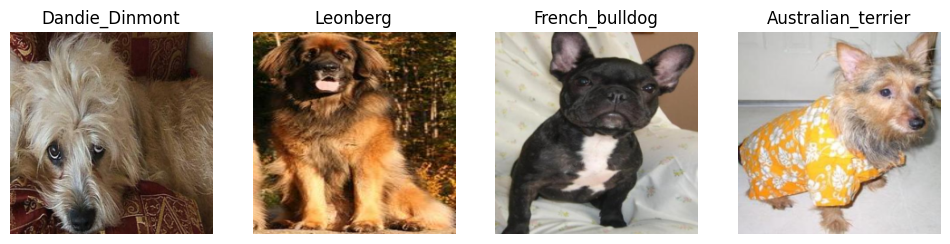

In [19]:
# Visualize a sample image
sample_images, sample_labels = next(iter(train_loader))
sample_images = sample_images.numpy()
sample_labels = sample_labels.numpy()

# Denormalize the images
sample_images = sample_images * 0.5 + 0.5

# Define classes
class_names = full_dataset.classes
print(class_names)

# Plot the images
fig, axes = plt.subplots(1, len(sample_images), figsize=(12, 4))
for idx, (image, label) in enumerate(zip(sample_images, sample_labels)):
    axes[idx].imshow(np.transpose(image, (1, 2, 0)))
    axes[idx].set_title(class_names[label])
    axes[idx].axis('off')
plt.show()

## Training Function

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

## Configuring the Convolutional Neural Network

Here, we start with the resnet18 CNN from PyTorch and customize it with our tuned hyperparameters as well as an additional linear layer to ensure a 120-class output as the final layer. 

In [24]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 120)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.7, weight_decay=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/tylertan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 38.0MB/s]


## Run the Training Loop

In [25]:
# Running training
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


KeyboardInterrupt: 

In [ ]:
# Save the model in the directory that contains the processed dataset
def generate_model_filename():
    now = datetime.now()
    formatted_date = now.strftime("%y-%m-%d-%H-%M")
    filename = f"model-{formatted_date}.pth"
    return filename

# Make a "models" dir if it doesn't exist
model_dir = 'models'
if not os.path.exists(model_dir):
    print(f'generating "{model_dir}" directory...')
    os.makedirs(model_dir)

curr_model_name = generate_model_filename()
curr_model_path = os.path.join(model_dir, curr_model_name)

torch.save(model_ft.state_dict(), curr_model_path)
print("Model saved successfully.")

## Model Test Accuracy

This section shows the sample predictions of random images and also calculates overall accuracy with the testing partition of the dataset.

In [ ]:


def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

model_ft.load_state_dict(torch.load(curr_model_path))
visualize_model(model_ft)

In [ ]:
# Calculating percentage accuracy of testing data

all_predictions = []
all_labels = []

# Set the model to evaluation mode and load state
model_ft.eval()
model_ft.load_state_dict(torch.load(curr_model_path))

# Disable gradient computation for inference
with torch.no_grad():
    # Iterate over the test data
    for inputs, labels in dataloaders['test']:
        # Forward pass
        outputs = model_ft(inputs)
        # Get the predicted class for each sample
        _, predicted = torch.max(outputs, 1)
        # print(f'predicted class: {predicted}')
        # Append the predictions and ground truth labels to the lists
        all_predictions.extend(predicted.tolist())
        all_labels.extend(labels.tolist())

# Calculate accuracy
correct = sum(1 for pred, label in zip(all_predictions, all_labels) if pred == label)
total = len(all_predictions)
accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')
